In [60]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

parent_directory = str(Path().resolve().parent)
parent_directory

import os,sys 
script_path = os.path.abspath("../src")  # Adjust the path
sys.path.append(script_path)
print(parent_directory)

/Users/yiminglin/Documents/Codebase/doc-provenance


In [87]:
import json 
import tiktoken

def read_json(path):
    if not os.path.exists(path):
        print('File not found!', path)
        return None
    with open(path, "r", encoding="utf-8") as file:
        data = json.load(file)
    return data

def count_tokens(text, model="gpt-4o-mini"):
    encoder = tiktoken.encoding_for_model(model)  # Get the tokenizer for the specific model
    tokens = encoder.encode(text)  # Encode text into tokens
    return len(tokens)

def write_json_to_file(filename, data):
    with open(filename, "w") as f:
        json.dump(data, f, indent=4)

In [78]:
def get_results(data_path, result_folder_path, sufficient_provenance_strategy, minimal_provenance_strategy, dataset):
    objects = read_json(data_path)
    results = {}
    strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
    i = 0
    for o in objects:
        i += 1
        if dataset == 'hotpotQA':
            title = o['document_name']
        else:
            title = o['id']
        result_path = result_folder_path + str(i) + '_' + str(title) + '_'  + strategy + '.json'
        if not os.path.exists(result_path):
            # if i <= 500:
            #     print('path not exist:', i)
            continue
        result = read_json(result_path)
        if 'tokens' not in result:
            # if i <= 500:
            #     print('result not exist:', i)
            continue
        r = {}
        #print(i, strategy)
        r['document_size'] = result['document_size']
        r['provenance_size'] = result['provenance_size']
        r['time'] = result['time']
        r['tokens'] = result['tokens']
        results[i] = r

    return results        

def get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path, dataset): 

    size_ratios = {}
    large_case_ids = {}
    medium_case_ids = {}

    for sufficient_provenance_strategy in sufficient_provenance_strategy_pool:
        for minimal_provenance_strategy in minimal_provenance_strategy_pool:
            strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
            if minimal_provenance_strategy != 'null':
                continue
            print(strategy)
            results = get_results(data_path, result_folder_path, sufficient_provenance_strategy, minimal_provenance_strategy, dataset)
            print(len(results))
            avg_provenance_size = 0
            avg_size_ratio = 0
            avg_time = 0
            avg_in_tokens = 0
            avg_out_tokens = 0
            size_ratio_list = []
            large_case_id = []
            medium_case_id = []
            for rid, result in results.items():
                size_ratio = result['provenance_size']/result['document_size']
                provenance_size = result['provenance_size']
                time = result['time']
                in_tokens = result['tokens'][0]
                out_tokens = result['tokens'][1] 

                avg_provenance_size += provenance_size
                avg_size_ratio += size_ratio
                avg_time += time 
                avg_in_tokens += in_tokens
                avg_out_tokens += out_tokens

                if size_ratio > 0.9:
                    large_case_id.append(rid)
                    #print('large size ratio:', rid)
                elif size_ratio < 0.9 and size_ratio > 0.3:
                    medium_case_id.append(rid)

                size_ratio_list.append(size_ratio)

                # print(rid) 
                # print('document_size, provenance_size:', result['document_size'], result['provenance_size'])
                # print('time:', result['time'])
                # print('tokens:', result['tokens'])
                # break
            avg_provenance_size /= len(results)
            avg_size_ratio /= len(results)
            avg_time /= len(results)
            avg_in_tokens /= len(results)
            avg_out_tokens /= len(results)
            print('provenance_size, size_ratio:', avg_provenance_size, avg_size_ratio)
            print('time:', avg_time)
            print('tokens:', avg_in_tokens, avg_out_tokens)
            print('')
            size_ratios[strategy] = size_ratio_list
            large_case_ids[strategy] = large_case_id
            medium_case_ids[strategy] = medium_case_id
    return size_ratios, large_case_ids, medium_case_ids

def plot_size_ratio_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios):
    # Prepare your strategies
    plots = []
    titles = []

    for sufficient_provenance_strategy in sufficient_provenance_strategy_pool:
        for minimal_provenance_strategy in minimal_provenance_strategy_pool:
            if minimal_provenance_strategy != 'null':
                continue
            strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
            print(strategy)
            a = size_ratios[strategy]
            plots.append(a)
            titles.append(strategy)

    # Set up subplots
    n = len(plots)
    cols = 3  # adjust columns as needed
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for i, (a, title) in enumerate(zip(plots, titles)):
        counts, bins, _ = axes[i].hist(a, bins='auto', edgecolor='black')
        total = counts.sum()
        percentages = (counts / total) * 100

        # Clear and re-plot using percentages
        axes[i].cla()
        axes[i].bar(bins[:-1], percentages, width=np.diff(bins), align='edge', edgecolor='black')
        axes[i].set_title(f'Histogram of {title}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency (Percentage)')
        axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

    # Hide any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [73]:
#nl_dev 

dataset = 'nl_dev'
sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down','embedding_sufficient_top_down','embedding_sufficient_bottem_up', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['exponential_greedy','sequential_greedy','null']

data_path = parent_directory + '/data/natural-questions_nq-dev-full.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/nl_dev/results/'

size_ratios_nl_dev, large_case_ids_nl_dev, medium_case_ids_nl_dev = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path,dataset)

    
                

LLM_score_sufficient_bottem_up_null
provenance_size, size_ratio: 1256.9683544303798 0.16382934813659375
time: 3.141283622270898
tokens: 4361.2468354430375 33.572784810126585

LLM_score_sufficient_top_down_null
provenance_size, size_ratio: 1970.0372881355931 0.23223341065795186
time: 4.187940395484536
tokens: 8291.908474576272 41.13898305084746

embedding_sufficient_top_down_null
provenance_size, size_ratio: 1425.3830508474575 0.2019846456411138
time: 3.613386133161642
tokens: 9896.93559322034 56.09152542372881

embedding_sufficient_bottem_up_null
provenance_size, size_ratio: 776.6276923076923 0.1273558362525617
time: 4.967069584039542
tokens: 13224.190769230769 127.60615384615384

divide_and_conquer_sufficient_null
provenance_size, size_ratio: 1176.4755700325734 0.1621284543751975
time: 4.329082325926045
tokens: 10463.70358306189 75.33876221498372



In [ ]:
for strategy, ids in large_case_ids_nl_dev.items():
    print(strategy)
    print(ids)
write_json_to_file(result_folder_path + 'new_large_cases.json', large_case_ids_nl_dev)

LLM_score_sufficient_bottem_up_null
[105, 145, 272]
LLM_score_sufficient_top_down_null
[13, 31, 42, 48, 79, 145, 173, 199, 267, 311, 341, 395, 404, 448]
embedding_sufficient_top_down_null
[2, 13, 30, 31, 34, 145, 231, 235, 262, 320, 369, 395, 404, 412, 498]
embedding_sufficient_bottem_up_null
[105, 145]
divide_and_conquer_sufficient_null
[31, 88, 119, 145, 167, 173, 296, 342, 369, 392, 393, 418, 422, 498]


In [74]:
for strategy, ids in medium_case_ids_nl_dev.items():
    print(strategy)
    print(ids)
write_json_to_file(result_folder_path + 'new_medium_cases.json', medium_case_ids_nl_dev)

LLM_score_sufficient_bottem_up_null
[3, 31, 60, 70, 75, 79, 96, 107, 118, 167, 173, 218, 224, 252, 257, 267, 273, 284, 286, 331, 333, 345, 360, 397, 466]
LLM_score_sufficient_top_down_null
[3, 60, 73, 75, 96, 107, 118, 119, 218, 252, 257, 273, 284, 286, 331, 333, 338, 345, 360, 403, 414, 466]
embedding_sufficient_top_down_null
[55, 60, 70, 75, 96, 107, 114, 150, 157, 173, 218, 225, 234, 267, 273, 285, 331, 393, 407, 466]
embedding_sufficient_bottem_up_null
[30, 60, 75, 96, 107, 114, 218, 234, 252, 267, 272, 273, 331, 341, 393, 407, 412, 418, 420]
divide_and_conquer_sufficient_null
[75, 96, 158, 214, 218, 235, 254, 257, 284, 285, 286, 320, 331, 338, 362, 448, 466]


In [90]:
def get_diff(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    common = set1 & set2
    return sorted(list((set1 | set2) - common))

result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/nl_dev/results/'

old_large_id_path = result_folder_path + 'large_cases.json' 
new_large_id_path = result_folder_path + 'new_large_cases.json'
old_medium_id_path = result_folder_path + 'medium_cases.json'
new_medium_id_path = result_folder_path + 'new_medium_cases.json'

old_lage_ids = read_json(old_large_id_path)
new_large_ids = read_json(new_large_id_path)
old_medium_ids = read_json(old_medium_id_path)
new_medium_ids = read_json(new_medium_id_path)

diff_ids = {}
for strategy, old_large_id in old_lage_ids.items():
    new_large_id = new_large_ids[strategy]
    large_diff = get_diff(old_large_id, new_large_id)
    print(strategy)
    # print(old_large_id)
    # print(new_large_id)
    # print(large_diff)
    old_medium_id = old_medium_ids[strategy]
    new_medium_id = new_medium_ids[strategy]
    medium_diff = get_diff(old_medium_id, new_medium_id)
    ids = sorted(set(large_diff + medium_diff)) 
    diff_ids[strategy] = ids
    # print(old_medium_id)
    # print(new_medium_id)
    # print(medium_diff)
write_json_to_file(result_folder_path + 'diff_ids.json', diff_ids)


LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_top_down_null
embedding_sufficient_top_down_null
embedding_sufficient_bottem_up_null
divide_and_conquer_sufficient_null


LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_top_down_null
embedding_sufficient_top_down_null
embedding_sufficient_bottem_up_null
divide_and_conquer_sufficient_null


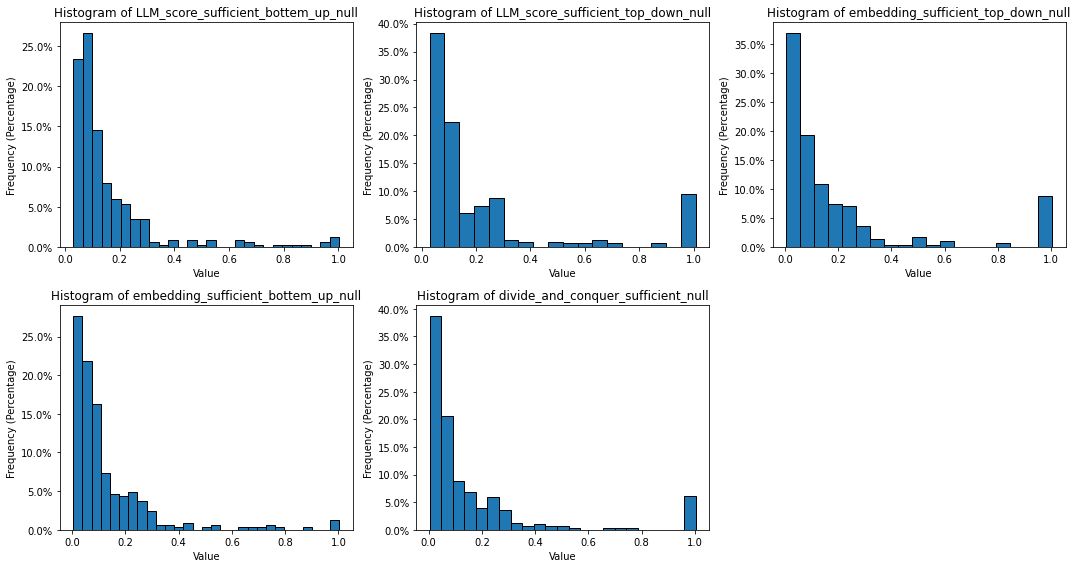

In [75]:

plot_size_ratio_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios_nl_dev)



In [76]:
#paper 

dataset = 'paper'
sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down','embedding_sufficient_top_down','embedding_sufficient_bottem_up', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['exponential_greedy','sequential_greedy','null']

data_path = parent_directory + '/data/qasper_sample_papers.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/paper/results/'

size_ratios_paper, large_case_ids_paper, medium_case_ids_paper = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path, dataset)

    
                

LLM_score_sufficient_bottem_up_null
provenance_size, size_ratio: 1002.2535545023696 0.17866682336472114
time: 3.998506580483857
tokens: 4720.144549763033 48.89099526066351

LLM_score_sufficient_top_down_null
provenance_size, size_ratio: 1171.6082191780822 0.21745740207830597
time: 3.884887488247597
tokens: 4423.695890410959 41.52602739726027

embedding_sufficient_top_down_null
provenance_size, size_ratio: 1257.8610354223433 0.23342978195753852
time: 3.273323503437094
tokens: 4641.310626702997 46.38964577656676

embedding_sufficient_bottem_up_null
provenance_size, size_ratio: 760.8132387706855 0.15651455443181866
time: 4.4897255035156896
tokens: 5790.945626477542 77.25059101654847

divide_and_conquer_sufficient_null
provenance_size, size_ratio: 847.7704485488126 0.16586671371446213
time: 4.194397009771543
tokens: 6733.44327176781 62.2532981530343



In [79]:
#paper 

dataset = 'paper'
sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down','embedding_sufficient_top_down','embedding_sufficient_bottem_up', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['exponential_greedy','sequential_greedy','null']

data_path = parent_directory + '/data/qasper_sample_papers.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/paper/results/'

size_ratios_paper, large_case_ids_paper, medium_case_ids_paper = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path, dataset)

    
                

LLM_score_sufficient_bottem_up_null
377
provenance_size, size_ratio: 660.1671087533157 0.12882001342525418
time: 3.2499394853171997
tokens: 2293.46949602122 26.084880636604776

LLM_score_sufficient_top_down_null
326
provenance_size, size_ratio: 1028.1349693251534 0.19210769203485445
time: 4.016267977609225
tokens: 4450.199386503067 40.88650306748466

embedding_sufficient_top_down_null
326
provenance_size, size_ratio: 1038.058282208589 0.20265727789003704
time: 3.4241137065770437
tokens: 4674.39263803681 45.25766871165644

embedding_sufficient_bottem_up_null
393
provenance_size, size_ratio: 624.1246819338422 0.12165194305530767
time: 3.6387969531479074
tokens: 4378.241730279899 47.712468193384225

divide_and_conquer_sufficient_null
353
provenance_size, size_ratio: 794.2407932011331 0.15471093186403767
time: 4.233135255808195
tokens: 6658.529745042493 59.991501416430594



In [65]:
for strategy, ids in large_case_ids_paper.items():
    print(strategy)
    print(ids)
write_json_to_file(result_folder_path + 'new_large_cases.json', large_case_ids_paper)

LLM_score_sufficient_bottem_up_null
[8, 361]
LLM_score_sufficient_top_down_null
[8, 48, 69, 132, 159, 167, 215, 276, 319, 333, 360, 361, 380, 421, 435, 438, 455, 473, 482, 483]
embedding_sufficient_top_down_null
[18, 24, 34, 48, 60, 122, 197, 215, 253, 292, 328, 341, 344, 380, 382, 415, 438, 455, 473, 497]
embedding_sufficient_bottem_up_null
[215, 473]
divide_and_conquer_sufficient_null
[8, 41, 47, 48, 50, 60, 80, 122, 131, 149, 150, 159, 185, 292, 310, 326, 344, 361, 380, 455, 473, 496]


In [80]:
for strategy, ids in medium_case_ids_paper.items():
    print(strategy)
    print(ids)
write_json_to_file(result_folder_path + 'new_medium_cases.json', medium_case_ids_paper)

LLM_score_sufficient_bottem_up_null
[60, 167, 178, 197, 319, 323, 341, 360, 397, 455, 473, 483, 486]
LLM_score_sufficient_top_down_null
[19, 143, 178, 197, 201, 323, 328, 331, 411]
embedding_sufficient_top_down_null
[19, 33, 42, 76, 150, 152, 168, 196, 219, 262, 263, 284, 326, 331, 435, 453]
embedding_sufficient_bottem_up_null
[18, 47, 69, 131, 150, 197, 221, 328, 341, 378, 453, 494, 497]
divide_and_conquer_sufficient_null
[33, 88, 197, 262, 341]


In [92]:
def get_diff(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    common = set1 & set2
    return sorted(list((set1 | set2) - common))

result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/paper/results/'

old_large_id_path = result_folder_path + 'large_cases.json' 
new_large_id_path = result_folder_path + 'new_large_cases.json'
old_medium_id_path = result_folder_path + 'medium_cases.json'
new_medium_id_path = result_folder_path + 'new_medium_cases.json'

old_lage_ids = read_json(old_large_id_path)
new_large_ids = read_json(new_large_id_path)
old_medium_ids = read_json(old_medium_id_path)
new_medium_ids = read_json(new_medium_id_path)

diff_ids = {}
for strategy, old_large_id in old_lage_ids.items():
    new_large_id = new_large_ids[strategy]
    large_diff = get_diff(old_large_id, new_large_id)
    print(strategy)
    # print(old_large_id)
    # print(new_large_id)
    # print(large_diff)
    old_medium_id = old_medium_ids[strategy]
    new_medium_id = new_medium_ids[strategy]
    medium_diff = get_diff(old_medium_id, new_medium_id)
    ids = sorted(set(large_diff + medium_diff)) 
    diff_ids[strategy] = ids
    # print(old_medium_id)
    # print(new_medium_id)
    # print(medium_diff)
write_json_to_file(result_folder_path + 'diff_ids.json', diff_ids)


LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_top_down_null
embedding_sufficient_top_down_null
embedding_sufficient_bottem_up_null
divide_and_conquer_sufficient_null


LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_top_down_null
embedding_sufficient_top_down_null
embedding_sufficient_bottem_up_null
divide_and_conquer_sufficient_null


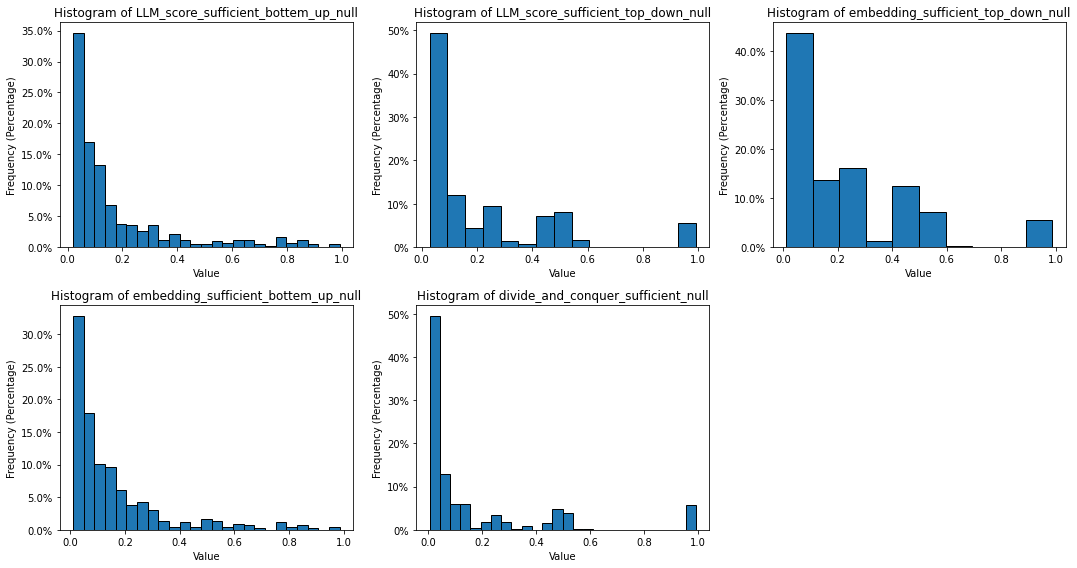

In [66]:
plot_size_ratio_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios_paper)



In [81]:
#hotpot 

dataset = 'hotpotQA'
sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down','embedding_sufficient_top_down','embedding_sufficient_bottem_up', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['exponential_greedy','sequential_greedy','null']

data_path = parent_directory + '/data/hotpotQA_fullwiki.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/hotpotQA/results/'

size_ratios_hotpot, large_case_ids_hotpot, medium_case_ids_hotpot = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path, dataset)

    
                

LLM_score_sufficient_bottem_up_null
310
provenance_size, size_ratio: 340.0 0.2844092653543175
time: 1.6014735260317403
tokens: 616.5419354838709 6.603225806451613

LLM_score_sufficient_top_down_null
305
provenance_size, size_ratio: 368.95081967213116 0.30444571151975075
time: 1.774425823180402
tokens: 978.3803278688524 8.767213114754098

embedding_sufficient_top_down_null
301
provenance_size, size_ratio: 366.3687707641196 0.3051952618249427
time: 4.2338358294528184
tokens: 1228.8671096345515 11.272425249169435

embedding_sufficient_bottem_up_null
316
provenance_size, size_ratio: 356.44620253164555 0.29513083109726346
time: 4.108421647850471
tokens: 772.0474683544304 7.575949367088608

divide_and_conquer_sufficient_null
306
provenance_size, size_ratio: 278.8888888888889 0.23014640292823776
time: 2.230546425370609
tokens: 1715.8790849673203 14.30718954248366



In [83]:
#hotpot 

dataset = 'hotpotQA'
sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down','embedding_sufficient_top_down','embedding_sufficient_bottem_up', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['exponential_greedy','sequential_greedy','null']

data_path = parent_directory + '/data/hotpotQA_fullwiki.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/hotpotQA/results/'

size_ratios_hotpot, large_case_ids_hotpot, medium_case_ids_hotpot = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path, dataset)

    
                

LLM_score_sufficient_bottem_up_null
294
provenance_size, size_ratio: 287.3775510204082 0.24822992006813688
time: 1.785233084847327
tokens: 444.6020408163265 5.098639455782313

LLM_score_sufficient_top_down_null
296
provenance_size, size_ratio: 353.1587837837838 0.29371695340139903
time: 1.8538886832224357
tokens: 970.7162162162163 8.516891891891891

embedding_sufficient_top_down_null
288
provenance_size, size_ratio: 355.8125 0.3025345791539321
time: 4.4676405977871685
tokens: 1210.7430555555557 11.020833333333334

embedding_sufficient_bottem_up_null
294
provenance_size, size_ratio: 300.1938775510204 0.25836676037235273
time: 3.833663581990871
tokens: 579.1326530612245 6.091836734693878

divide_and_conquer_sufficient_null
297
provenance_size, size_ratio: 261.020202020202 0.2186452699354881
time: 2.3207723500351314
tokens: 1713.828282828283 14.424242424242424



In [82]:
for strategy, ids in medium_case_ids_hotpot.items():
    print(strategy)
    print(ids)
write_json_to_file(result_folder_path + 'medium_cases.json', medium_case_ids_hotpot)

LLM_score_sufficient_bottem_up_null
[11, 15, 22, 25, 29, 35, 38, 39, 45, 46, 52, 72, 79, 81, 84, 90, 91, 121, 122, 123, 126, 129, 133, 134, 145, 149, 151, 177, 179, 186, 197, 200, 204, 208, 216, 220, 222, 233, 234, 235, 254, 262, 264, 269, 277, 283, 285, 302, 313, 326, 332, 335, 345, 368, 373, 374, 389, 397, 398, 399, 401, 403, 405, 407, 411, 413, 414, 415, 418, 426, 434, 435, 438, 448, 453, 460, 464, 465, 469, 470, 471, 473, 478, 483, 487, 492]
LLM_score_sufficient_top_down_null
[9, 15, 19, 26, 29, 33, 36, 38, 39, 46, 79, 81, 84, 90, 91, 121, 122, 123, 129, 145, 149, 151, 179, 186, 190, 191, 197, 204, 208, 220, 233, 234, 235, 254, 262, 264, 266, 269, 277, 283, 285, 297, 302, 308, 336, 345, 351, 368, 369, 373, 374, 379, 389, 392, 399, 403, 411, 413, 414, 415, 418, 426, 433, 434, 435, 438, 441, 448, 450, 452, 453, 460, 465, 469, 473, 478, 487, 492]
embedding_sufficient_top_down_null
[9, 23, 25, 29, 38, 39, 42, 45, 46, 55, 71, 88, 90, 91, 121, 122, 138, 145, 151, 153, 156, 163, 177, 179,

In [94]:
for strategy, ids in medium_case_ids_hotpot.items():
    print(strategy)
    print(ids)
write_json_to_file(result_folder_path + 'new_medium_cases.json', medium_case_ids_hotpot)

LLM_score_sufficient_bottem_up_null
[15, 29, 72, 91, 122, 123, 126, 149, 151, 179, 197, 204, 208, 220, 234, 254, 262, 269, 277, 283, 302, 313, 332, 345, 374, 389, 397, 403, 411, 413, 414, 426, 434, 438, 448, 453, 465, 469, 470, 471, 478, 492]
LLM_score_sufficient_top_down_null
[9, 19, 29, 79, 91, 122, 123, 149, 151, 179, 197, 208, 234, 254, 262, 266, 277, 283, 297, 302, 308, 345, 351, 368, 374, 389, 403, 411, 413, 414, 433, 434, 438, 450, 453, 465, 469, 473, 478, 492]
embedding_sufficient_top_down_null
[23, 29, 39, 42, 71, 88, 90, 91, 121, 145, 153, 156, 177, 179, 183, 186, 189, 190, 216, 228, 234, 242, 254, 262, 269, 277, 286, 294, 297, 302, 313, 332, 345, 350, 374, 392, 396, 399, 401, 412, 434, 438, 439, 464, 469, 470, 474, 476]
embedding_sufficient_bottem_up_null
[12, 23, 29, 39, 42, 55, 71, 72, 88, 90, 91, 121, 122, 145, 153, 156, 173, 177, 179, 186, 189, 228, 234, 254, 255, 262, 269, 277, 286, 294, 297, 302, 313, 332, 345, 350, 351, 374, 382, 389, 392, 399, 401, 412, 413, 434, 438

In [95]:
def get_diff(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    common = set1 & set2
    return sorted(list((set1 | set2) - common))

result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/hotpotQA/results/'

old_large_id_path = result_folder_path + 'large_cases.json' 
new_large_id_path = result_folder_path + 'new_large_cases.json'
old_medium_id_path = result_folder_path + 'medium_cases.json'
new_medium_id_path = result_folder_path + 'new_medium_cases.json'

old_lage_ids = read_json(old_large_id_path)
new_large_ids = read_json(new_large_id_path)
old_medium_ids = read_json(old_medium_id_path)
new_medium_ids = read_json(new_medium_id_path)

diff_ids = {}
for strategy, old_large_id in old_lage_ids.items():
    new_large_id = new_large_ids[strategy]
    large_diff = get_diff(old_large_id, new_large_id)
    print(strategy)
    # print(old_large_id)
    # print(new_large_id)
    # print(large_diff)
    old_medium_id = old_medium_ids[strategy]
    new_medium_id = new_medium_ids[strategy]
    medium_diff = get_diff(old_medium_id, new_medium_id)
    ids = sorted(set(large_diff + medium_diff)) 
    diff_ids[strategy] = ids
    # print(old_medium_id)
    # print(new_medium_id)
    # print(medium_diff)
write_json_to_file(result_folder_path + 'diff_ids.json', diff_ids)


LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_top_down_null
embedding_sufficient_top_down_null
embedding_sufficient_bottem_up_null
divide_and_conquer_sufficient_null


LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_top_down_null
embedding_sufficient_top_down_null
embedding_sufficient_bottem_up_null
divide_and_conquer_sufficient_null


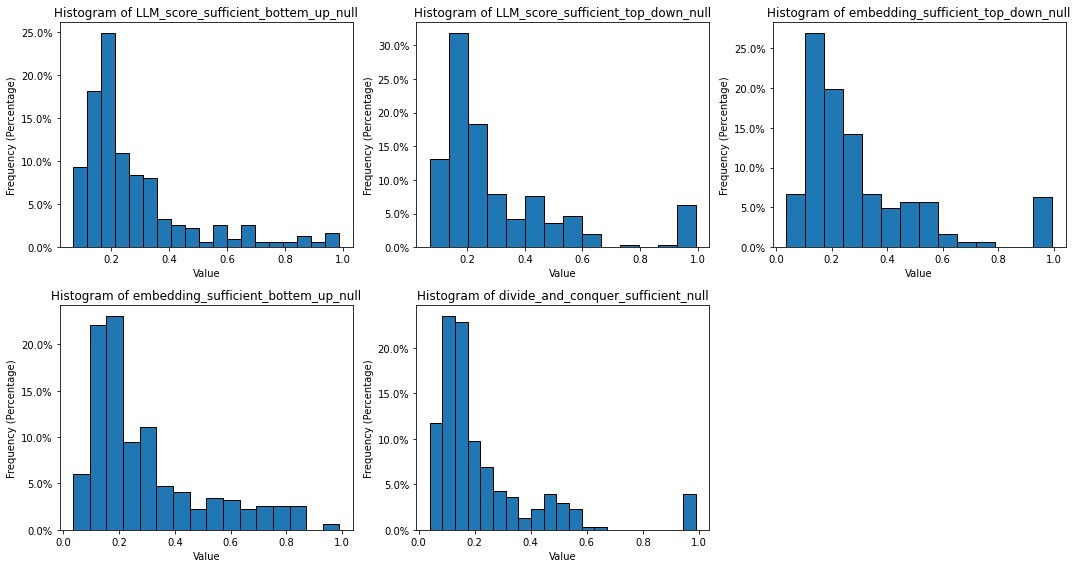

In [69]:
plot_size_ratio_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios_hotpot)

